Dataset: The German Traffic Sign Recognition Benchmark (GTSRB) dataset is recommended for this project. It is well-labeled and commonly used in academic and practical projects.

In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahemateja19bec1025/traffic-sign-dataset-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'traffic-sign-dataset-classification' dataset.
Path to dataset files: /kaggle/input/traffic-sign-dataset-classification


In [19]:
import os

dataset_root = path  # Use the value printed by kagglehub
print(os.listdir(dataset_root))


['traffic_Data', 'labels.csv']


In [21]:
data_dir = os.path.join(dataset_root, 'traffic_Data')
print(os.listdir(data_dir))

['DATA', 'TEST']


In [22]:
data_folder = os.path.join(data_dir, 'DATA')
print(os.listdir(data_folder))

['7', '47', '17', '19', '22', '2', '35', '50', '23', '10', '5', '36', '20', '45', '27', '41', '39', '32', '25', '42', '52', '8', '38', '12', '55', '49', '0', '31', '53', '34', '18', '28', '56', '16', '13', '26', '15', '3', '43', '1', '30', '14', '4', '57', '9', '46', '21', '44', '40', '6', '11', '37', '51', '33', '54', '48', '29', '24']


In [25]:
import pandas as pd

# Build a DataFrame of image paths and labels (class numbers as strings)
image_paths = []
labels = []

for class_folder in os.listdir(data_folder):
    class_path = os.path.join(data_folder, class_folder)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(class_path, fname))
                labels.append(class_folder)  # label is the folder name (still as string for now)

df_images = pd.DataFrame({'image_path': image_paths, 'label': labels})


In [26]:
print(df_images['label'].value_counts().head())
print(df_images.head())

label
28    446
54    324
3     260
5     194
55    162
Name: count, dtype: int64
                                          image_path label
0  /kaggle/input/traffic-sign-dataset-classificat...     7
1  /kaggle/input/traffic-sign-dataset-classificat...     7
2  /kaggle/input/traffic-sign-dataset-classificat...     7
3  /kaggle/input/traffic-sign-dataset-classificat...     7
4  /kaggle/input/traffic-sign-dataset-classificat...     7


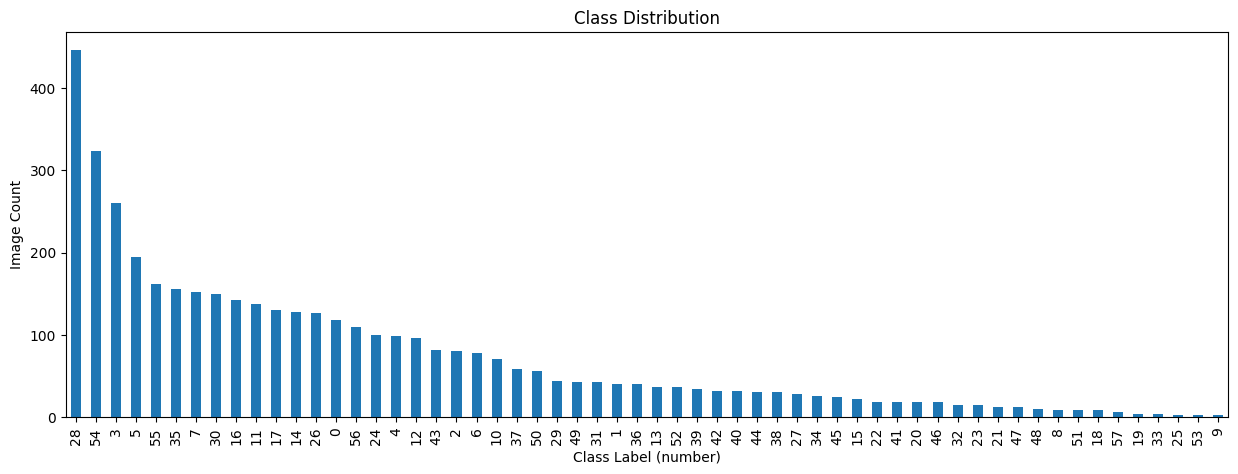

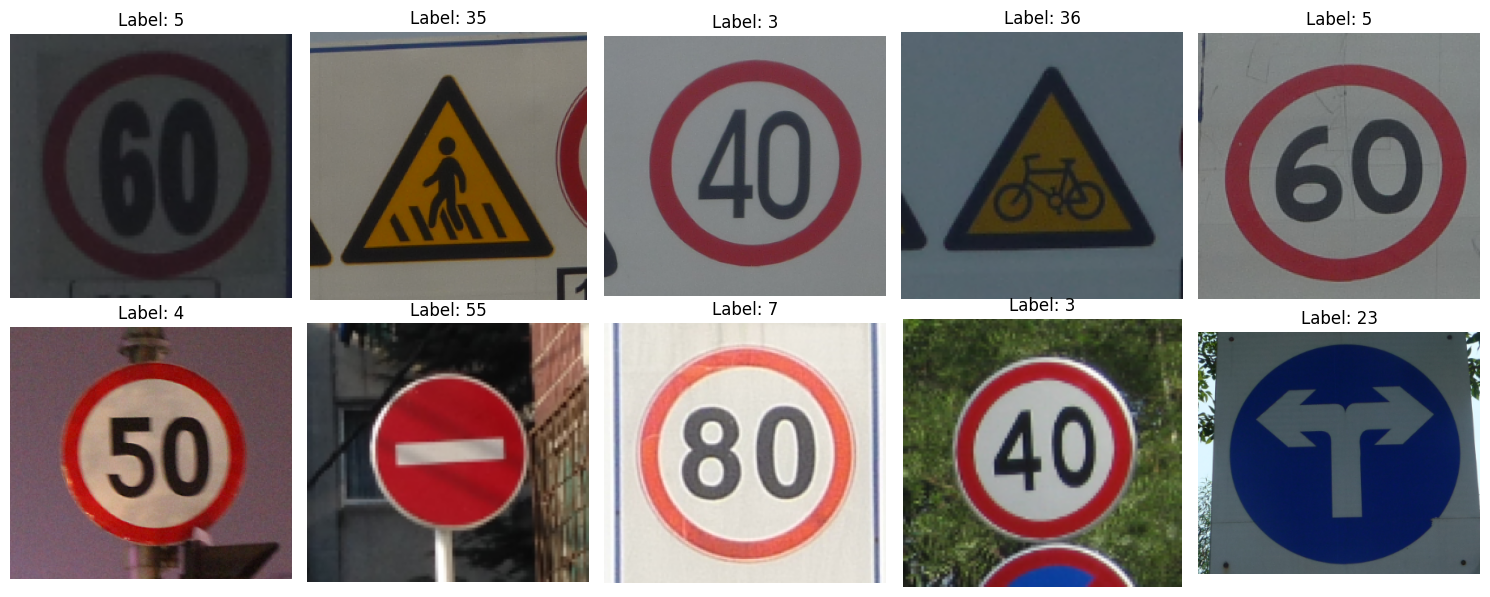

In [27]:
import matplotlib.pyplot as plt
import cv2

# 1. Plot class distribution
plt.figure(figsize=(15, 5))
df_images['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class Label (number)')
plt.ylabel('Image Count')
plt.show()

# 2. Visualize a few random images with labels
sample = df_images.sample(10)
plt.figure(figsize=(15, 6))
for i, row in enumerate(sample.itertuples()):
    img = cv2.imread(row.image_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {row.label}')
        plt.axis('off')
plt.tight_layout()
plt.show()


Convert images into fixed-length, informative numerical features using the Histogram of Oriented Gradients (HOG) descriptor.
HOG captures shapes and edges, making it effective for image classification using SVM/Random Forest.

In [28]:
from skimage.feature import hog
import numpy as np

hog_features = []
labels = []

for row in df_images.itertuples():
    img = cv2.imread(row.image_path)
    if img is None:
        continue  # skip broken image
    # Convert to grayscale for HOG descriptor
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.resize(img_gray, (64, 64))  # Standard size for consistency
    feature = hog(
        img_gray,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        orientations=9,
        block_norm='L2-Hys',
        visualize=False
    )
    hog_features.append(feature)
    labels.append(int(row.label))  # Convert label string to integer

# Turn lists into arrays for ML model input
X = np.array(hog_features)
y = np.array(labels)
print("Features shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique classes:", np.unique(y))


Features shape: (4170, 1764)
Labels shape: (4170,)
Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train labels:", np.unique(y_train))
print("Test labels:", np.unique(y_test))


Train shape: (3336, 1764) Test shape: (834, 1764)
Train labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
Test labels: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 54 55 56 57]


In [31]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Train SVM classifier
clf_svm = SVC(kernel='linear', random_state=42)
clf_svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = clf_svm.predict(X_test)
print("=== SVM Classification Report ===")
print(classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


=== SVM Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00         8
           2       0.89      1.00      0.94        16
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        39
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00         2
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00        28
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00        26
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00        28
          17       1.00      1.00      1.00    

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np # Import numpy for np.unique

# Train Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = clf_rf.predict(X_test)
print("=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred_rf))

# Calculate and store the Random Forest Confusion Matrix
# Get the unique labels from the combined training and testing data
unique_labels = np.unique(y) # Use labels from the full dataset
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=unique_labels) # Store confusion matrix in cm_rf
print("Random Forest Confusion Matrix:")
print(cm_rf) # Print the stored confusion matrix

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        16
           3       0.96      1.00      0.98        52
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        39
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00         2
          10       1.00      1.00      1.00        14
          11       0.93      1.00      0.97        28
          12       1.00      1.00      1.00        19
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00        26
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00        28
          17       1.00      1.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Below code is not essential


t-SNE (t-distributed Stochastic Neighbor Embedding)

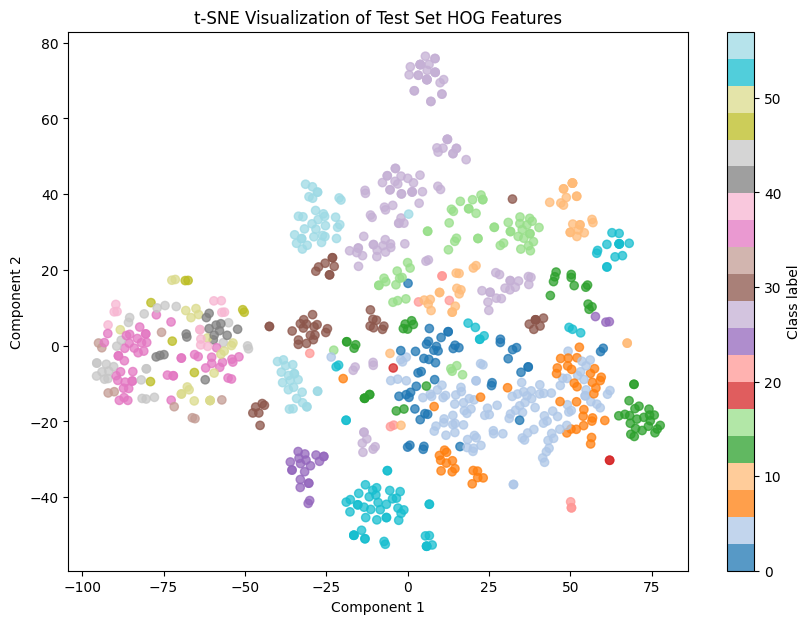

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Run t-SNE on all test samples
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_vis = tsne.fit_transform(X_test)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_test, cmap='tab20', alpha=0.75)
plt.colorbar(scatter, label='Class label')
plt.title("t-SNE Visualization of Test Set HOG Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


UMAP (Uniform Manifold Approximation and Projection)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


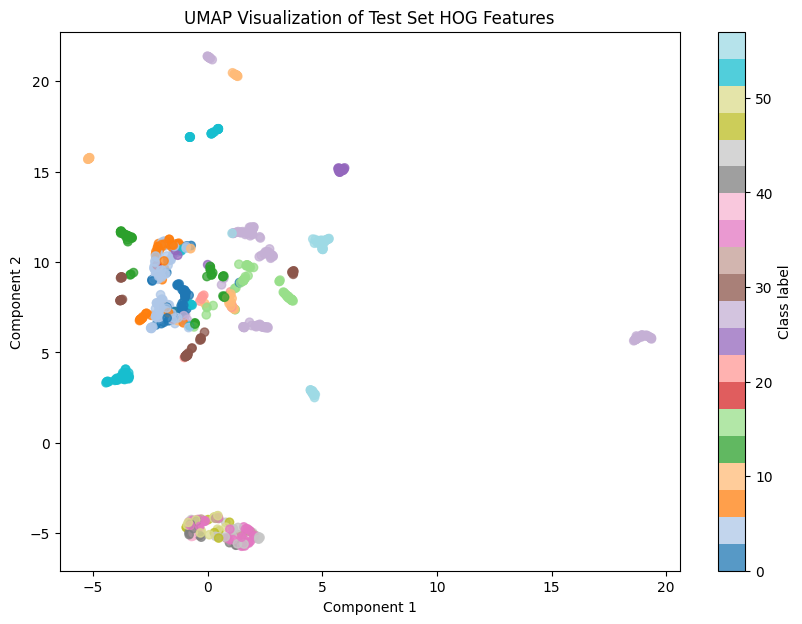

In [47]:
import umap
import matplotlib.pyplot as plt

# Fit UMAP on all X_test samples (HOG features)
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_test)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_test, cmap='tab20', alpha=0.75)
plt.colorbar(scatter, label='Class label')
plt.title("UMAP Visualization of Test Set HOG Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

